# Cell cycle model CCRMV003

Packages

In [1]:
#using DifferentialEquations
using OrdinaryDiffEq, ParameterizedFunctions, NamedTuples
using PyDSTool, PyCall, PyPlot
using JLD

In [2]:
include("custom_functions.jl");
include("plot_functions.jl");

In [3]:
@load "CCMMV001_data.jld"
bif1_stst = curve_stst
bif1_lcycle = curve_lcycle
bif1_fold1 = curve_fold1
bif3_stst = curve_stst2
bif3_lcycle = curve_lcycle2;

In [4]:
@load "CCCMV001_data.jld"
bif2_stst = curve_stst
bif2_lcycle = curve_lcycle;

## Model system of ODE's

A model for the cell cycle and radiation that captures G2/M transition, cell division and radiation pathway is given by

\begin{align}
\frac{d MPF}{dt}       &= k_{m0}Mass - (k_{m2} + k_{m2a}Wee1)\cdot MPF + (k_{m1} + k_{m1a}Cdc25)\cdot MPF_{P} - (k_{m3} + k_{m3a} APC)MPF, \\ 
\frac{d MPF_{P}}{dt}   & = (k_{m2} + k_{m2b}Wee1)\cdot MPF - (k_{m1} + k_{m1a}Cdc25)\cdot MPF_{P} - (k_{m3}+ k_{m3a} APC)MPF_{P},  \\
\frac{d Wee1}{dt}      &= V_{w1} \frac{Wee1_{T} - Wee1 }{J_{w1} + (Wee1_{T} - Wee1) }  - k_{w2} (MPF + \alpha MPF_{P}) \frac{Wee1}{J_{w2} + Wee1}, \\
\frac{d Cdc25}{dt} &= k_{c1} (MPF + \alpha MPF_{P}) \frac{Cdc25_{T} - Cdc25}{J_{c1} + (Cdc25_{T} - Cdc25)}  - (V_{c2}+k_{c2a}Chk2)\frac{Cdc25}{J_{c2} + Cdc25}, \\
\frac{d IE}{dt}    &= k_{i1} (MPF + \alpha MPF_{P})\frac{IE_{T} - IE}{J_{i1} + (IE_{T} - IE)} - V_{i2} \frac{IE}{J_{i2} + IE}, \\       
\frac{d APC}{dt}   &= k_{a1}IE \frac{APC_{T} - APC}{J_{a1}+(APC_{T} - APC)} - V_{a2}\frac{APC}{J_{a2}+APC}, \\
\frac{d Mass}{dt}      &= \mu Mass \left( 1 - \frac{Mass}{K_{Mass}} \right),\\
\frac{d Chk2}{dt}  &= k_{h1} ATM \, DSB \frac{Chk2_{T} - Chk2 }{J_{h1} + (Chk2_{T} - Chk2) }  - V_{h2} \frac{Chk2}{J_{h2} + Chk2},\\  
\frac{d ATM}{dt}       &= k_{t1}DSB\frac{ATM_{T}-ATM}{J_{t1}+ATM_{T}-ATM}- V_{t2}\frac{ATM}{J_{t2}+ATM},\\
\frac{d DSB}{dt}       &= k_{d1} \dot D(t) - k_{d2}ATM\,DSB.
\end{align}

The first seven equation correspond to the Cell Cycle module, and the last three equations correspond to the Radiation pathway module. The parameters has been chosen to adapt the cell cycle behaviour.

The question of interest is how radiation affects the cell cell cycle dynamics, in particular, the G2/M trasition. If we want to investigate the effect of radiation on other components of the cell cycle, the module for the cell cycle must be modified to account for the these components.

 **Definition of the model**

In [5]:
HeaviSide(t, a, b) = (a < t < b) ? 1. : 0.
f = @ode_def_bare CCRMV003 begin
    ## System of ODE (vector field)
    dMPF   = k_m0*Mass - (k_m2 + k_m2a*Wee1)*MPF + (k_m1 + k_m1a*Cdc25)*MPF_P - (k_m3 + k_m3a*APC)*MPF
    dMPF_P = (k_m2 + k_m2a*Wee1)*MPF - (k_m1 + k_m1a*Cdc25)*MPF_P - (k_m3 + k_m3a*APC)*MPF_P
    dWee1  = V_w1*(Wee1_T - Wee1)/(J_w1 + Wee1_T - Wee1) - k_w2*(MPF + MPF_P*α)*Wee1/(J_w2 + Wee1)
    dCdc25 = k_c1*(MPF + MPF_P*α)*(Cdc25_T - Cdc25)/(J_c1 + Cdc25_T - Cdc25) - (V_c2+k_c2a*Chk2)*Cdc25/(J_c2 + Cdc25)
    dIE    = k_i1*(MPF + MPF_P*α)*(IE_T - IE)/(J_i1 + IE_T - IE) - V_i2*IE/(J_i2 + IE)
    dAPC   = k_a1*IE*(APC_T - APC)/(J_a1 + APC_T - APC) - V_a2*APC/(J_a2 + APC)
    dMass  = μ*Mass*(1 - Mass/K_Mass)
    dChk2  = k_h1*ATM*DSB*(Chk2_T - Chk2)/(J_h1 + Chk2_T - Chk2) - V_h2*Chk2/(J_h2 + Chk2)
    dATM   = k_t1*DSB*(ATM_T - ATM)/(J_t1 + ATM_T - ATM) - V_t2*ATM/(J_t2 + ATM)
    dDSB   = -k_d2*ATM*DSB + k_d1*RadScheme(t)
end k_m0 k_m1 k_m1a k_m2 k_m2a k_m3 k_m3a V_w1 k_w2 J_w1 J_w2 k_c1 V_c2 k_c2a J_c1 J_c2 k_i1 V_i2 J_i1 J_i2 k_a1 V_a2 J_a1 J_a2 k_h1 V_h2 J_h1 J_h2 k_t1 V_t2 J_t1 J_t2 k_d1 k_d2 α μ K_Mass Wee1_T Cdc25_T IE_T APC_T Chk2_T ATM_T θ_M

(::CCRMV003) (generic function with 2 methods)

Where the parameters are given by

In [6]:
p0 = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.4, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    k_h1=0.32, V_h2=1.9, J_h1=0.01, J_h2=0.01, k_t1=30.0, V_t2=3.8, J_t1=0.01, J_t2=0.01, k_d1=35.00, k_d2=0.4, 
    α=0.05, μ=0.07, K_Mass=2.7, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, ATM_T=1.0, θ_M=0.2)

(k_m0 = 0.2, k_m1 = 0.4, k_m1a = 20.0, k_m2 = 0.4, k_m2a = 50.0, k_m3 = 0.2, k_m3a = 6.35, V_w1 = 1.0, k_w2 = 5.3, J_w1 = 0.01, J_w2 = 0.01, k_c1 = 8.5, V_c2 = 1.4, k_c2a = 2.4, J_c1 = 0.01, J_c2 = 0.01, k_i1 = 1.7, V_i2 = 0.4, J_i1 = 0.001, J_i2 = 0.001, k_a1 = 6.8, V_a2 = 1.7, J_a1 = 0.001, J_a2 = 0.001, k_h1 = 0.32, V_h2 = 1.9, J_h1 = 0.01, J_h2 = 0.01, k_t1 = 30.0, V_t2 = 3.8, J_t1 = 0.01, J_t2 = 0.01, k_d1 = 35.0, k_d2 = 0.4, α = 0.05, μ = 0.07, K_Mass = 2.7, Wee1_T = 1.0, Cdc25_T = 1.0, IE_T = 1.0, APC_T = 1.0, Chk2_T = 1.0, ATM_T = 1.0, θ_M = 0.2)

**Cell division events**

When the concentration of MPF crosses the threshold for mitosis $\theta_M$ from positive to negative, the mass on the cell splits in two.

In [7]:
function division(u,t,integrator)
    # MPF crosses threshold
    u[1] - p0.θ_M
end # division

function division_event!(integrator)
    # Divide mass in two
    integrator.u[7] = integrator.u[7]/2
end # division_event!

# Event happens from positive to negative
cb = ContinuousCallback(division, nothing, division_event!, save_positions=(true,false))

DiffEqBase.ContinuousCallback{#division,Void,#division_event!,DiffEqBase.#INITIALIZE_DEFAULT,Float64,Int64,Void}(division, nothing, division_event!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, (true, false), 1.0e-9, 0)

### Test solutions

The following solution are illustrative examples of the effet of radiation on the G2/M transition.

**Cell cycle**. No radiation, control case.

In [8]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 40.0)
dtmax = 0.001
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, p0)
RadScheme(t) = 0.
solnorad = solve(prob, alg, callback=cb; (:dtmax, dtmax))
solnorad.errors

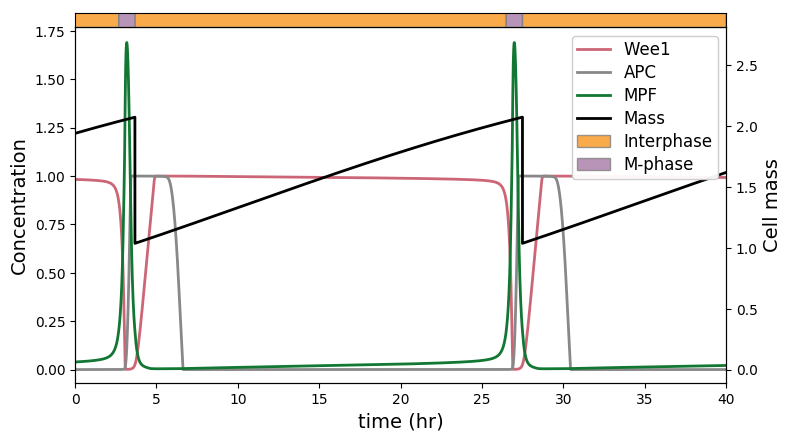

In [9]:
fig = PlotSolution(solnorad)
savefig("figures/CCRMV003_fig_solnorad.pdf", bbox_inches="tight")

The plot shows one full cell cycle. During interphase, the concentration of active MPF is low and Wee1 is fully active; but as the concentration of MPF increases as a result of cell growth, the activity of MPF reaches the threshold for mitosis $\theta_M=0.2$, and the cell enters mitosis. During M-phase, Wee1 becomes inactive, the concentration of MPF increases and decreases as APC becomes active. Right after the MPF concentration decreases to $\theta_M=0.2$, the cel division event divides the cell mass in two.

**Radiation scheme: pusle of 0.4Gy moments before mitotic entry.**

In [10]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 40)
dtmax = 0.001
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, p0)
# Radiation scheme: 
# 0.4*60 Gy/min*min/hr starts at 1.5 hrs for 1/60 hrs
rad_rate = 0.4
t_0 = 2.3; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
solrad1 = solve(prob, alg, callback=cb; (:dtmax, dtmax))
solrad1.errors

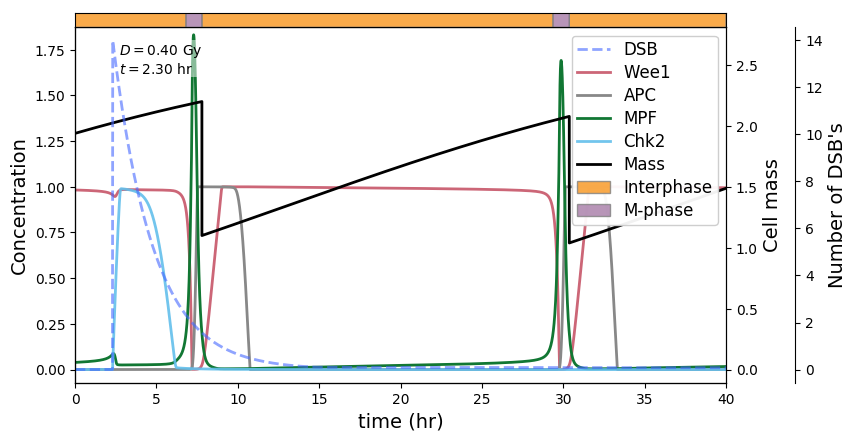

In [11]:
fig = PlotSolution(solrad1, [t_0, t_d, rad_rate])
savefig("figures/CCRMV003_fig_solrad1.pdf", bbox_inches="tight")

Mitotic entry is delayed (around 15 h) after induced radiation. Radiation dose is low but sufficiently high to delay mitosis.

**Radiation scheme: pulse of 0.2 Gy moments before mitosis.** Same time but lower intensity for the radiation pulse.

In [12]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 40.0)
dtmax = 0.001
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, p0)
# Radiation scheme: 
# 0.2*60 Gy/min*min/hr starts at 1.5 hrs for 1/60 hrs
rad_rate = 0.2
t_0 = 2.3; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
solrad2 = solve(prob, alg, callback=cb; (:dtmax, dtmax))
solrad2.errors

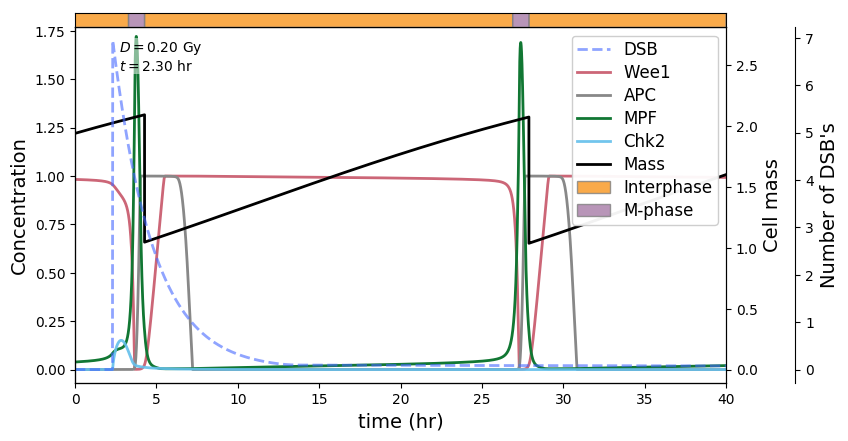

In [13]:
fig = PlotSolution(solrad2, [t_0, t_d, rad_rate])
savefig("figures/CCRMV003_fig_solrad2.pdf", bbox_inches="tight")

Mitotic entry is unaffected after induced radiation. Radiation dose is too low to induce a quick response.

**Radiation scheme: pulse of 0.2Gy few more moments before radiation.** Same radiation intensity but 12 min (0.2 hr) before comprared to previous case.

In [14]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 40.0)
dtmax = 0.001
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, p0)
# Radiation scheme: 
# 0.2*60 Gy/min*min/hr starts at 1.2 hrs for 1/60 hrs
rad_rate = 0.2
t_0 = 2.1; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
solrad3 = solve(prob, alg, callback=cb; (:dtmax, dtmax))
solrad3.errors

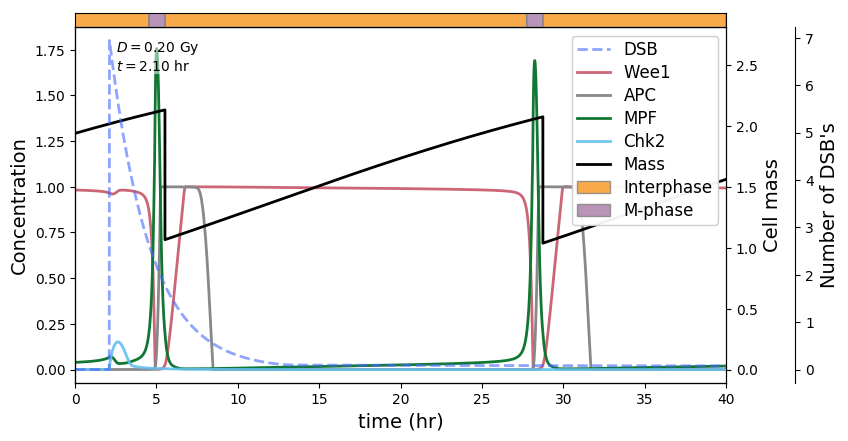

In [15]:
fig = PlotSolution(solrad3, [t_0, t_d, rad_rate])
savefig("figures/CCRMV003_fig_solrad3.pdf", bbox_inches="tight")

Mitotic entry is delayed eventhough the intensity is very low, but it happened enough time before mitosis so the response could be activated.

### Bifurcation diagram: total inactivation rate of Cdc25 ($V_{c2}+k_{c2a}Chk2_P$)

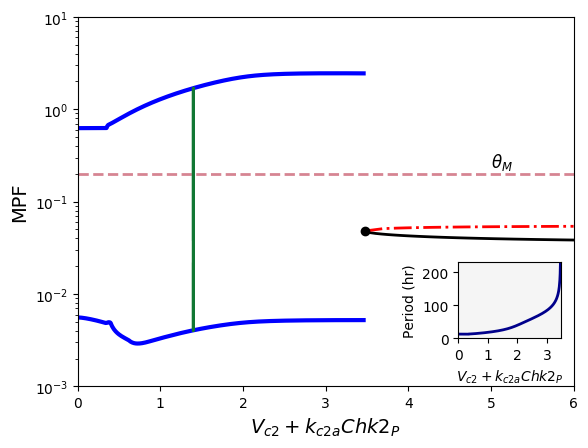

In [24]:
plot([0.0, 6.0], [0.2, 0.2], "--", color=red1, lw=2, alpha=0.8)
text(5.0, 0.21, L"θ_M", va="bottom", fontsize=12)
PlotBifurcation(bif2_stst, (:V_c2, :MPF))
PlotBifurcation(bif2_lcycle, (:V_c2, :MPF))
plot(p0.V_c2 + p0.k_c2a*solnorad[8, :], solnorad[1, :], color=green2, lw=2)
xlim([0, 6])
xlabel(L"V_{c2} + k_{c2a} Chk2_P", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.001, 10])
# Inset for the length of the cell cycle
fig = gcf()
ax = fig[:add_axes]([0.72, 0.21, 0.16, 0.16], facecolor="WhiteSmoke")
ax[:plot](bif2_lcycle.d[:V_c2], bif2_lcycle.d[:MPF][:period], color="DarkBlue", lw=2)
axis([0.0, bif2_stst.special_points["LP"][1][:V_c2], 0.0, maximum(bif2_lcycle.d[:MPF][:period])])
xlabel(L"V_{c2} + k_{c2a} Chk2_P")
ylabel("Period (hr)")
ax[:set_xticks]([0.0, 1.0, 2.0, 3.0])
ax[:set_yticks]([0.0, 100.0, 200.0]);
savefig("figures/CCRMV003_fig_bif1_norad.pdf", bbox_inches="tight")

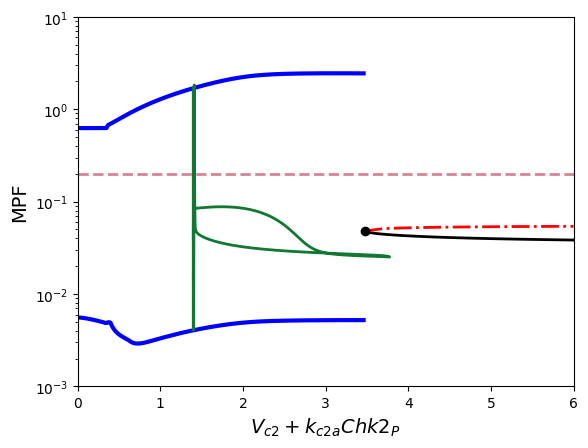

In [17]:
plot([0.0, 6.0], [0.2, 0.2], "--", color=red1, lw=2, alpha=0.8)
PlotBifurcation(bif2_stst, (:V_c2, :MPF))
PlotBifurcation(bif2_lcycle, (:V_c2, :MPF))
plot(p0.V_c2 + p0.k_c2a*solrad1[8, :], solrad1[1, :], color=green2, lw=2)
xlim([0, 6])
xlabel(L"V_{c2} + k_{c2a} Chk2_P", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.001, 10])
savefig("figures/CCRMV003_fig_bif1_rad1.pdf", bbox_inches="tight")

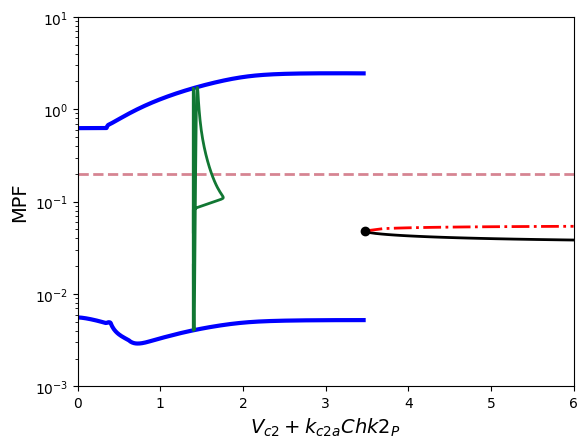

In [18]:
plot([0.0, 6.0], [0.2, 0.2], "--", color=red1, lw=2, alpha=0.8)
PlotBifurcation(bif2_stst, (:V_c2, :MPF))
PlotBifurcation(bif2_lcycle, (:V_c2, :MPF))
tt = linspace(1.2, 40.0, 1000)
plot(p0.V_c2 + p0.k_c2a*solrad2(tt)[8, :], solrad2(tt)[1, :], color=green2, lw=2)
xlim([0, 6])
xlabel(L"V_{c2} + k_{c2a} Chk2_P", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.001, 10])
savefig("figures/CCRMV003_fig_bif1_rad2.pdf", bbox_inches="tight")

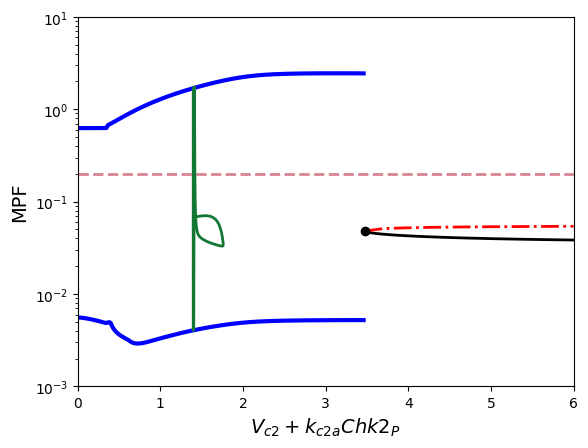

In [19]:
plot([0.0, 6.0], [0.2, 0.2], "--", color=red1, lw=2, alpha=0.8)
PlotBifurcation(bif2_stst, (:V_c2, :MPF))
PlotBifurcation(bif2_lcycle, (:V_c2, :MPF))
tt = linspace(1.2, 40.0, 1000)
plot(p0.V_c2 + p0.k_c2a*solrad3(tt)[8, :], solrad3(tt)[1, :], color=green2, lw=2)
xlim([0, 6])
xlabel(L"V_{c2} + k_{c2a} Chk2_P", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.001, 10])
savefig("figures/CCRMV003_fig_bif1_rad3.pdf", bbox_inches="tight")

### Bifurcation diagram: cell mass (cell size) in the intephase module

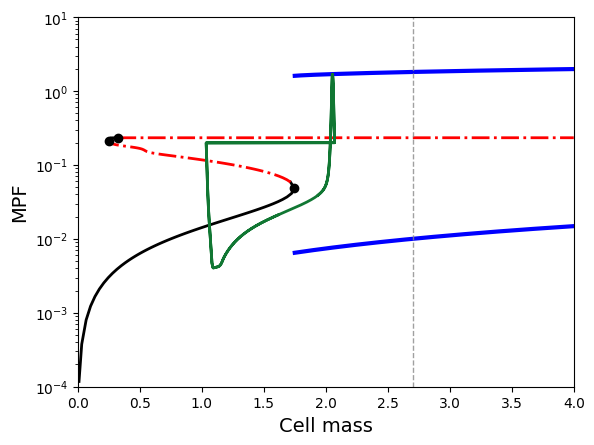

In [50]:
PlotBifurcation(bif1_stst, (:Mass, :MPF))
PlotBifurcation(bif1_lcycle, (:Mass, :MPF))
plot(solnorad[7, :], solnorad[1, :], color=green2, lw=2)
plot([p0.K_Mass, p0.K_Mass], [0.0, 10.0], color=gray1, "--", lw=1, alpha=0.8)
xlim([0, 4])
xlabel("Cell mass", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.0001, 10])
title("")
show()
savefig("figures/CCRMV003_fig_bif2_norad.pdf", bbox_inches="tight")

Cell cycle trajectory on the mass bifurcation diagram

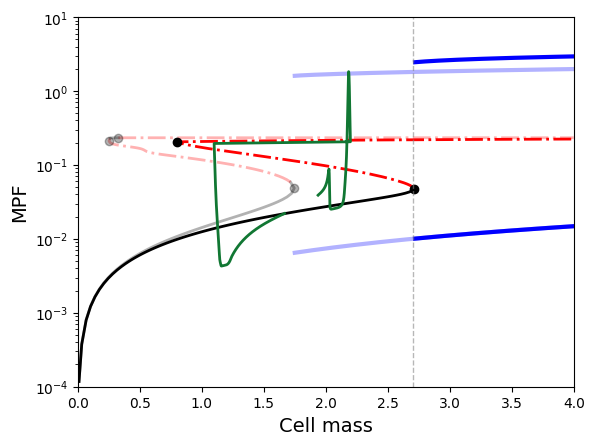

In [54]:
PlotBifurcation(bif1_stst, (:Mass, :MPF))
PlotBifurcation(bif1_lcycle, (:Mass, :MPF))
lns = gca()[:lines]
for k in 1:length(lns)
    lns[k][:set_alpha](0.3)
end
PlotBifurcation(bif3_stst, (:Mass, :MPF))
PlotBifurcation(bif3_lcycle, (:Mass, :MPF))
plot([p0.K_Mass, p0.K_Mass], [0.0, 10.0], color=gray1, "--", lw=1, alpha=0.6)
tt = 0:0.01:20
plot(solrad1(tt)[7, :], solrad1(tt)[1, :], color=green2, lw=2)
xlim([0, 4])
xlabel("Cell mass", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.0001, 10])
title("")
savefig("figures/CCRMV003_fig_bif2_rad1.pdf", bbox_inches="tight")

**Two parameter bifurcation**: Mass and $V_{c2}$

Three fold points: first limit point (SNIC), second limit point (saddle-node), and Hopf point

In [22]:
@show V_c2 = bif2_stst.special_points["LP"][1][:V_c2];

V_c2 = ((bif2_stst.special_points["LP"])[1])[:V_c2] = 3.471683398405677


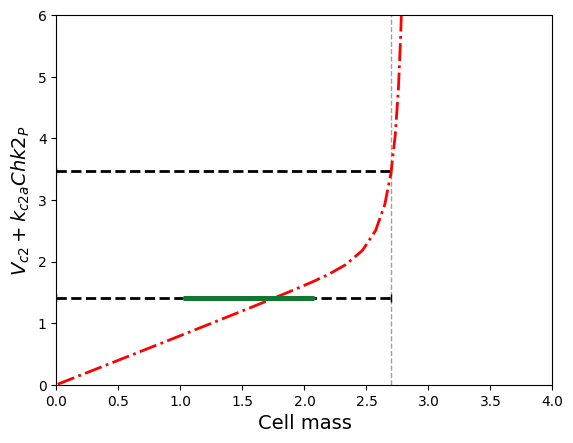

In [56]:
# Base lines
plot([p0.K_Mass, p0.K_Mass], [0.0, 10.0], color=gray1, "--", lw=1, alpha=0.8)
plot([0.0, p0.K_Mass], [p0.V_c2, p0.V_c2], color="k", lw=2, "--|")
SNIC_V_c2 = bif2_stst.special_points["LP"][1][:V_c2]
plot([0.0, p0.K_Mass], [SNIC_V_c2, SNIC_V_c2], color="k", lw=2, "--|")
# Fold bifurcation curve
PlotBifurcation(bif1_fold1, (:Mass, :V_c2))
# Superimposed solutions
plot(solnorad[7, :], p0.V_c2 + p0.k_c2a*solnorad[8, :], color=green2, lw=3)
xlim([0, 4])
xlabel("Cell mass", fontsize=14)
ylim([0, 6])
ylabel(L"V_{c2}+k_{c2a}Chk2_P", fontsize=14)
savefig("figures/CCRMV003_fig_bif3_norad.pdf", bbox_inches="tight")

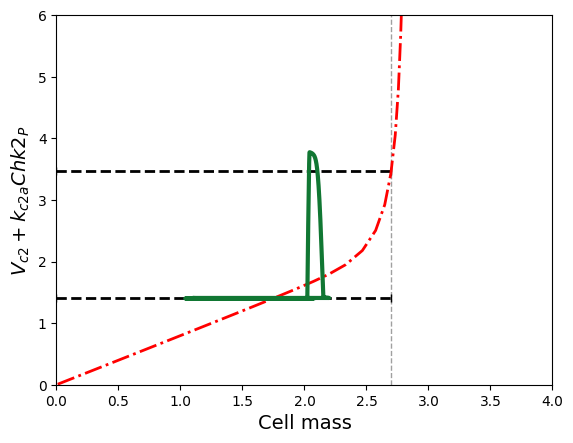

In [57]:
# Base lines
plot([p0.K_Mass, p0.K_Mass], [0.0, 10.0], color=gray1, "--", lw=1, alpha=0.8)
plot([0.0, p0.K_Mass], [p0.V_c2, p0.V_c2], color="k", lw=2, "--|")
SNIC_V_c2 = bif2_stst.special_points["LP"][1][:V_c2]
plot([0.0, p0.K_Mass], [SNIC_V_c2, SNIC_V_c2], color="k", lw=2, "--|")
# Fold bifurcation curve
PlotBifurcation(bif1_fold1, (:Mass, :V_c2))
# Superimposed solutions
plot(solrad1[7, :], p0.V_c2 + p0.k_c2a*solrad1[8, :], color=green2, lw=3)
xlim([0, 4])
xlabel("Cell mass", fontsize=14)
ylim([0, 6])
ylabel(L"V_{c2}+k_{c2a}Chk2_P", fontsize=14)
savefig("figures/CCRMV003_fig_bif3_rad1.pdf", bbox_inches="tight")

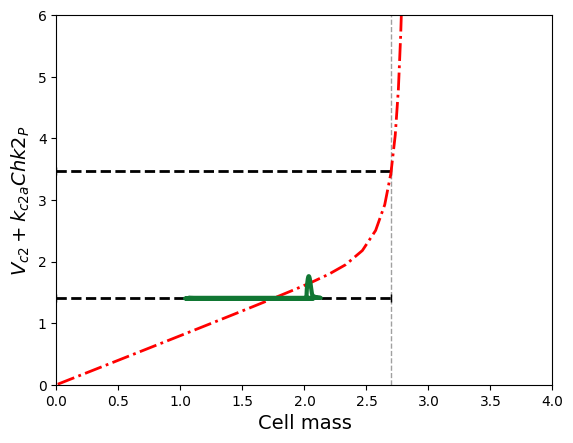

In [60]:
# Base lines
plot([p0.K_Mass, p0.K_Mass], [0.0, 10.0], color=gray1, "--", lw=1, alpha=0.8)
plot([0.0, p0.K_Mass], [p0.V_c2, p0.V_c2], color="k", lw=2, "--|")
SNIC_V_c2 = bif2_stst.special_points["LP"][1][:V_c2]
plot([0.0, p0.K_Mass], [SNIC_V_c2, SNIC_V_c2], color="k", lw=2, "--|")
# Fold bifurcation curve
PlotBifurcation(bif1_fold1, (:Mass, :V_c2))
# Superimposed solutions
plot(solrad3[7, :], p0.V_c2 + p0.k_c2a*solrad3[8, :], color=green2, lw=3)
xlim([0, 4])
xlabel("Cell mass", fontsize=14)
ylim([0, 6])
ylabel(L"V_{c2}+k_{c2a}Chk2_P", fontsize=14)
savefig("figures/CCRMV003_fig_bif3_rad2.pdf", bbox_inches="tight")

### Below shoud be the experiment matching (Rothkamm 2003, etc)

**Radiation scheme: pulse of 0.1Gy few more moments before radiation.** Same radiation intensity but 12 min (0.2 hr) before comprared to previous case.

In [179]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 25.0)
dtmax = 0.001
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, p0)
# Radiation scheme: 
# 0.3*60 Gy/min*min/hr starts at 1.5 hrs for 1/60 hrs
rad_rate = 0.1
t_0 = 1.0; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
solrad4 = solve(prob, alg, callback=cb; (:dtmax, dtmax))
solrad4.errors

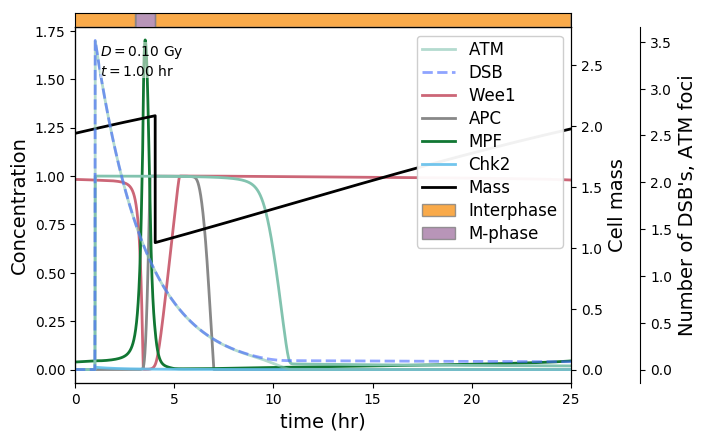

In [180]:
fig = PlotSolution(solrad4, [t_0, t_d, rad_rate]);
#savefig("figures/CCRMV002_fig_solrad2.pdf")

**Radiation scheme: pulse of 0.1Gy few more moments before radiation.** Same radiation intensity but 12 min (0.2 hr) before comprared to previous case.

In [177]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 25.0)
dtmax = 0.001
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, p0)
# Radiation scheme: 
# 0.3*60 Gy/min*min/hr starts at 1.5 hrs for 1/60 hrs
rad_rate = 0.020
t_0 = 1.0; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
solrad4 = solve(prob, alg, callback=cb; (:dtmax, dtmax))
solrad4.errors

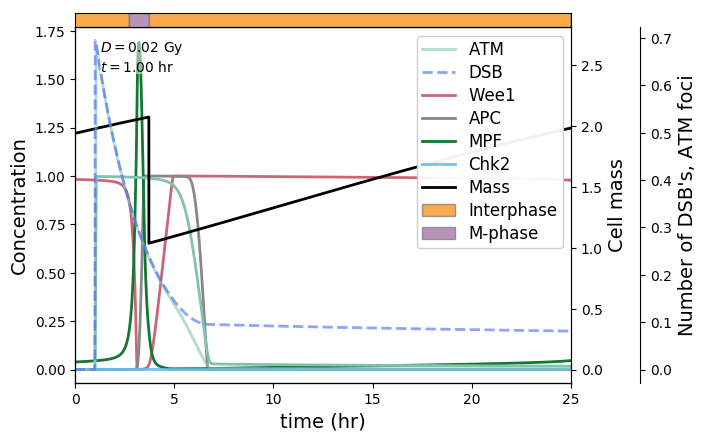

In [178]:
fig = PlotSolution(solrad4, [t_0, t_d, rad_rate]);
#savefig("figures/CCRMV002_fig_solrad2.pdf")

**Radiation scheme: pulse of 0.1Gy few more moments before radiation.** Same radiation intensity but 12 min (0.2 hr) before comprared to previous case.

In [175]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 25.0)
dtmax = 0.001
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, p0)
# Radiation scheme: 
# 0.3*60 Gy/min*min/hr starts at 1.5 hrs for 1/60 hrs
rad_rate = 0.005
t_0 = 1.0; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
solrad4 = solve(prob, alg, callback=cb; (:dtmax, dtmax))
solrad4.errors

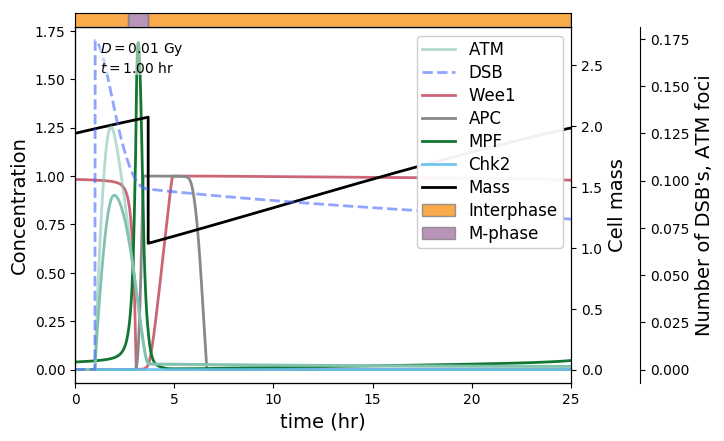

In [176]:
fig = PlotSolution(solrad4, [t_0, t_d, rad_rate]);
#savefig("figures/CCRMV002_fig_solrad2.pdf")

**Radiation scheme: pulse of 0.1Gy few more moments before radiation.** Same radiation intensity but 12 min (0.2 hr) before comprared to previous case.

In [173]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 25.0)
dtmax = 0.001
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, p0)
# Radiation scheme: 
# 0.3*60 Gy/min*min/hr starts at 1.5 hrs for 1/60 hrs
rad_rate = 0.0012
t_0 = 1.0; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
solrad4 = solve(prob, alg, callback=cb; (:dtmax, dtmax))
solrad4.errors

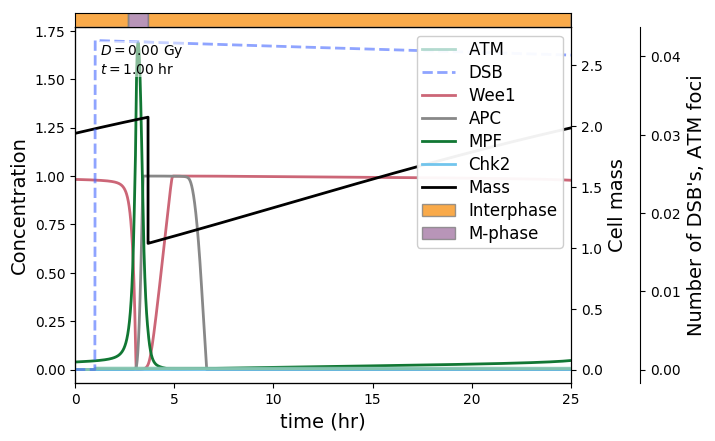

In [174]:
fig = PlotSolution(solrad4, [t_0, t_d, rad_rate]);
#savefig("figures/CCRMV002_fig_solrad2.pdf")

**Radiation scheme: pulse of 0.12Gy before radiation.** Very low radiation intensity anytime before mitosis, all DSBs are irreperable.

In [30]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 40.0)
dtmax = 0.001
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, p0)
# Radiation scheme: 
# 0.3*60 Gy/min*min/hr starts at 1.2 hrs for 1/60 hrs
rad_rate = 0.0012
t_0 = 1.0; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
solrad4 = solve(prob, alg, callback=cb; (:dtmax, dtmax))
solrad4.errors

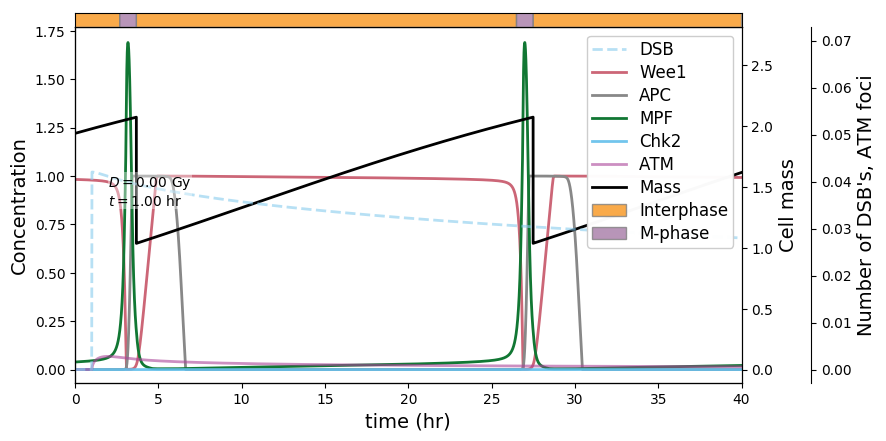

In [31]:
include("plot_functions.jl");
fig = PlotSolution(solrad4, [t_0, t_d, rad_rate])
fig[:set_size_inches]((8.6, 4.8));
#savefig("figures/CCRMV002_fig_solrad4.pdf")

Mitotic entry is not affected at all, and the cell enters mitosis without properly responding to DNA damage.

**Radiation scheme: pulse of 1.0Gy before radiation.** High radiation intensity very close to mitosis.

In [113]:
p = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.2, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    k_h1a=0.1, V_h2=1.9, J_h1=0.01, J_h2=0.01, k_t1=30.0, V_t2=3.8, J_t1=0.01, J_t2=0.01, k_d1=35.00, k_d2=0.4, 
    α=0.05, μ=0.07, K_Mass=2.7, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, ATM_T=1.0, θ_M=0.2)
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 20.0)
dtmax = 0.001
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, p)
# Radiation scheme: 
# ?*60 Gy/min*min/hr starts at 1.2 hrs for 1/60 hrs
rad_rate = 0.09
t_0 = 1.0; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
solrad5 = solve(prob, alg, callback=cb; (:dtmax, dtmax))
solrad5.errors

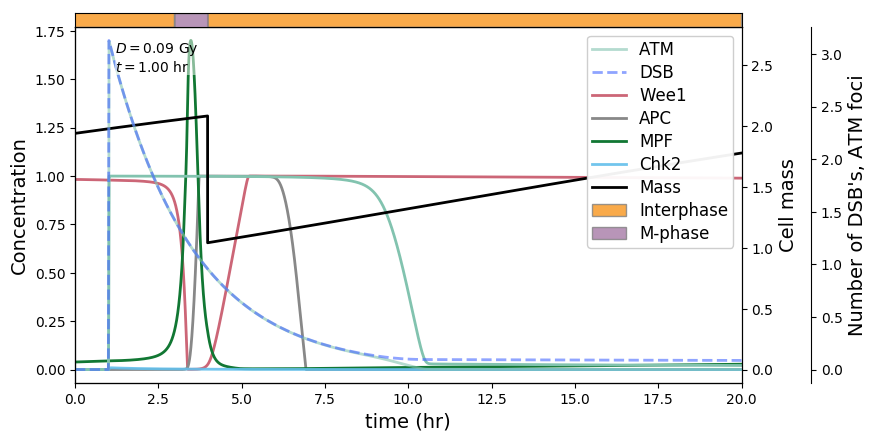

In [112]:
include("plot_functions.jl");
fig = PlotSolution(solrad5, [t_0, t_d, rad_rate])
fig[:set_size_inches]((8.6, 4.8));
#savefig("figures/CCRMV002_fig_solrad4.pdf")

Cell increases in size after every division.

In [5]:
bif2_stst.special_points["LP"][1][:MPF]

0.04804437261120631

### Radiation effect